In [1]:
KD_path = "ThuanHoa/KhoanhDat/ThuanHoa_TKDD2022.shp"
KetQuaPhanLoaiDat = "KetQuaPhanLoaiDat.tif"

In [2]:
import geopandas as gpd
import rasterio
import os
import rioxarray
import numpy as np
import xarray as xr

In [3]:
## map code
CODE_MAP = {
    "BHK": 2,
    "CLN": 3,
    "DGD": 6,
    "DGT": 6,
    "DNL": 6,
    "DRA": 6,
    "DSH": 6,
    "DTL": 5,
    "DTS": 6,
    "DYT": 6,
    "LUC": 1,
    "NKH": 3,
    "NTD": 6,
    "NTS": 4,
    "ONT": 6,
    "SKC": 6,
    "SKX": 6,
    "SON": 5,
    "TMD": 6,
    "TON": 6,
    "TSC": 6,
}

HT_MAP = {
    "NN": {
        "name": "Đất Nông Nghiệp",
        "data": [1, 2, 3, 4]
    },
    "PNN": {
        "name": "Đất Phi Nông Nghiệp",
        "data": [6]
    },
    "TQ": {
        "name": "Đất Thổ Quả",
        "data": [15]
    }
}

In [4]:
gdf = gpd.read_file(KD_path, crs="EPSG:9209")
polygon = gdf.geometry.values
label = gdf.tenchu.values
squares =  gdf.dientich.values

/home/kaito/miniconda3/envs/deafrica-tools-env/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [ ]:
gdf

In [102]:
gdf.dientich

0        5058.2
1         407.6
2        4537.2
3         397.9
4        3016.7
         ...   
1127      286.0
1128    11359.0
1129      470.9
1130      341.9
1131     2307.4
Name: dientich, Length: 1132, dtype: float64

In [6]:
label

array(['SKC', 'ONT', 'ONT(1782.60);CLN(2754.70)', ..., 'ONT',
       'ONT(297.10);CLN(44.80)', 'ONT(1485.50);CLN(821.90)'], dtype=object)

<Axes: >

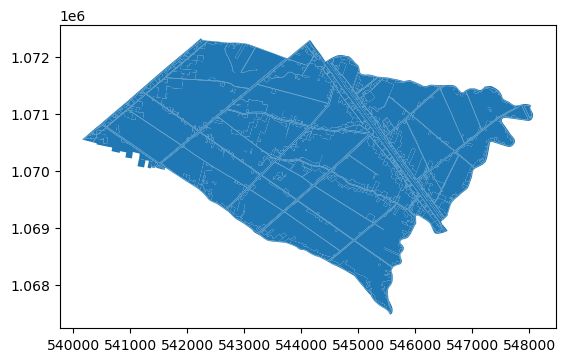

In [6]:
gdf.plot()

In [15]:
print(gdf.geometry[0])

POLYGON ((540179.7 1070550.084, 540209.964 1070575.703, 540210.764 1070577.703, 540212.264 1070577.653, 540297.974 1070574.813, 540315.563 1070574.23, 540301.202 1070519.021, 540179.7 1070550.084))


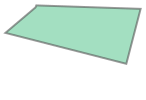

In [16]:
gdf.geometry.iloc[0]

import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union
import rasterio

def sample_points_on_edge(polygon, distance=1.0):
    """Generate points along the edge of the polygon."""
    exterior_coords = list(polygon.exterior.coords)
    points_on_edge = []
    for i in range(len(exterior_coords) - 1):
        start, end = exterior_coords[i], exterior_coords[i + 1]
        line = LineString([start, end])
        # Generate points at intervals along the edge
        distance_along_edge = np.arange(0, line.length, distance)
        for d in distance_along_edge:
            point = line.interpolate(d)
            points_on_edge.append(point)
    return points_on_edge


print(sample_points_on_edge(gdf.geometry[0]))



In [11]:
ouput_image = rioxarray.open_rasterio(KetQuaPhanLoaiDat)

<xarray.DataArray (band: 1, y: 532, x: 830)> Size: 4MB
[441560 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
  * y            (y) float64 4kB 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

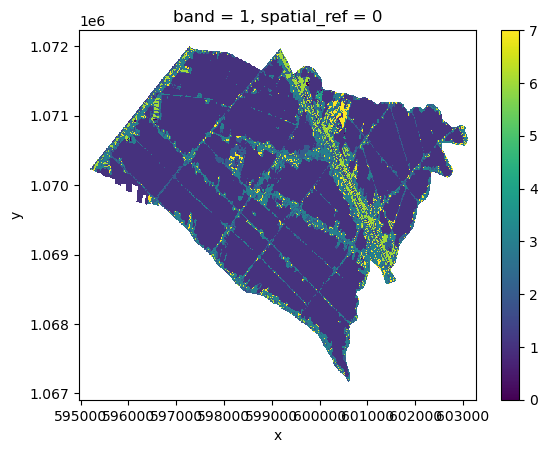

In [12]:
ouput_image.plot()
ouput_image

In [13]:
import importlib
import utils

importlib.reload(utils)
result, sub_result = utils.process(HT_MAP, polygon, label, CODE_MAP, ouput_image, squares)

process NN
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
No data found in bounds.
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
tuple index out of range
No data found in bounds.
tuple index ou

In [16]:
############################################change into funtions######################################
result = {}
sub_result= {}
for key, values in HT_MAP.items():
    print(f"process {key}")
    array_list = []
    deleted_array = []
    for i in range(len(polygon)):
        po = polygon[i]
        lb = label[i]
        code_lb = CODE_MAP.get(lb, 15)
        s = 0
        try:
            qr = ouput_image.rio.clip([po], "EPSG:9209")
            if code_lb in values["data"]:
                if code_lb == 6:
                    qr = qr.where((qr != 6.0), np.nan)
                    # qr = qr.where((qr != 3.0), np.nan)
                elif code_lb == 15:
                    qr = qr.where((qr != 6.0), np.nan)
                    qr = qr.where((qr != 3.0), np.nan)
                else: 
                    qr = qr.where(qr != float(code_lb), np.nan)
                
                
            else:
                qr.values[:, :, :] = np.nan
            #calculate square and eliminte small pieces 
            new_qr = utils.eliminate_noise(qr, squares[i])
            print(squares[i])
            
            array_list.append(qr)
            deleted_array.append(new_qr)
        except Exception as e:
           print(f"Error {e}")
    result.update({key: array_list})
    sub_result.update({key: deleted_array})

281836.3
2545.0
683.6
1853.6
Error tuple index out of range
16016.8
Error tuple index out of range
1889.9
1048.6
Error tuple index out of range
3191.7
Error tuple index out of range
288.0
Error tuple index out of range
4773.3
1287.8
882.2
6251.5
539.6
6864.1
2040.4
Error tuple index out of range
Error tuple index out of range
5338.0
1036.8
2394.6
1838.7
Error tuple index out of range
504.4
301537.7
3686.5
1196.8
1898.0
Error tuple index out of range
216124.7
770.7
Error tuple index out of range
8167.7
3071.2
12134.3
48259.9
3652.9
286.0
11359.0
470.9
341.9
2307.4
process PNN
5058.2
407.6
4537.2
397.9
3016.7
906.4
2501.7
521.7
3148.1
4187.5
734.2
3011.9
Error tuple index out of range
1087.0
2657.4
6696.3
741.3
Error tuple index out of range
391.4
1311.4
1117.5
18103.3
5223.4
5117.4
6161.6
558.0
1717.6
1164.8
614.9
625.2
2595.1
7124.4
225.3
2157.1
384.2
2366.2
3583.4
16825.6
825.6
Error tuple index out of range
171514.5
3440.3
2549.4
9879.7
Error tuple index out of range
290.4
2066.8
310

In [8]:
import utils
result, sub_presult = utils.process(HT_MAP, polygon, label, CODE_MAP, ouput_image)

process NN
process PNN
process TQ


In [24]:
result

{'NN': [], 'PNN': [], 'TQ': []}

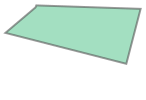

<xarray.DataArray (band: 1, y: 5, x: 13)>
array([[[nan, nan,  2.,  2.,  6.,  2.,  2.,  7.,  2.,  2.,  3.,  3.,
          3.],
        [nan,  6.,  2.,  2.,  6.,  6.,  2.,  7.,  3.,  3.,  3.,  2.,
          2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  2.,
          1.],
        [nan, nan, nan, nan,  7.,  7.,  2.,  2.,  3.,  3.,  3.,  2.,
         nan],
        [nan, nan, nan, nan, nan, nan, nan, nan,  3.,  3.,  3.,  3.,
         nan]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.952e+05 5.952e+05 ... 5.953e+05 5.953e+05
  * y            (y) float64 1.07e+06 1.07e+06 1.07e+06 1.07e+06 1.07e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [101]:
po = polygon[0]
qr = ouput_image.rio.clip([po], "EPSG:9209")
display(po)
qr

In [17]:
result

{'NN': [<xarray.DataArray (band: 1, y: 5, x: 13)>
  array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan],
          [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan],
          [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan],
          [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan],
          [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan]]])
  Coordinates:
    * band         (band) int64 1
    * x            (x) float64 5.952e+05 5.952e+05 ... 5.953e+05 5.953e+05
    * y            (y) float64 1.07e+06 1.07e+06 1.07e+06 1.07e+06 1.07e+06
      spatial_ref  int64 0
  Attributes:
      AREA_OR_POINT:  Area
      scale_factor:   1.0
      add_offset:     0.0,
  <xarray.DataArray (band: 1, y: 3, x: 2)>
  array([[[nan, nan],
          [nan, nan],
          [nan, nan]]])
  Coordinates:
    * band         (band) int64 1
    * x            (x) floa

In [ ]:
sub_result

In [102]:
test = xr.DataArray(np.random.rand(3,3), dims=['x', 'y'])
test = test *10
test = test.where(test>5, 0)
test

<xarray.DataArray (x: 3, y: 3)>
array([[5.10942001, 0.        , 5.63266924],
       [8.37634064, 7.34653038, 8.1392791 ],
       [7.25012133, 9.15675985, 0.        ]])
Dimensions without coordinates: x, y

In [18]:
from rioxarray.merge import merge_arrays
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
colors = [
    "#abcee9",
    "#ffffc0",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]
cmap = ListedColormap(colors)

/tmp/ipykernel_2171/485899268.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


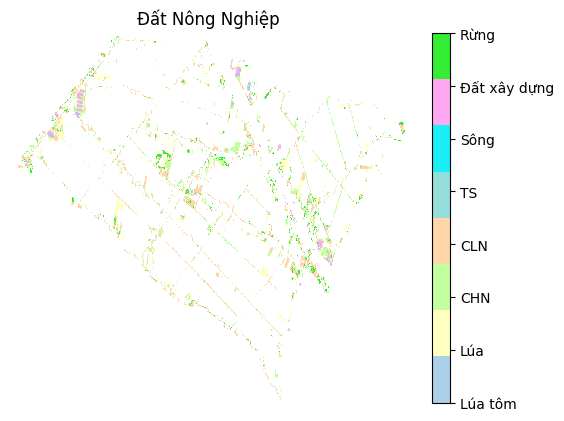

/tmp/ipykernel_2171/485899268.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


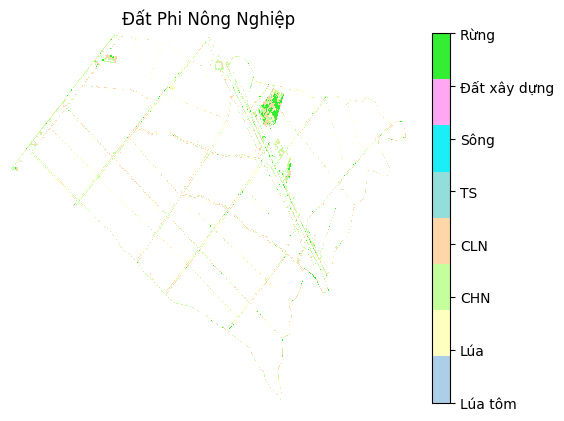

/tmp/ipykernel_2171/485899268.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


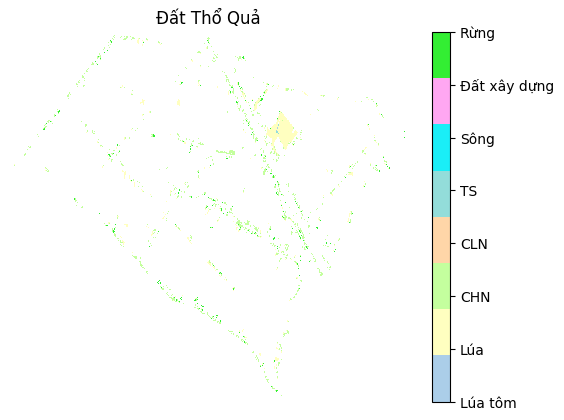

In [19]:
save_path = "ThuanHoa/KetQua"
if not os.path.exists(save_path):
    os.mkdir(save_path)

for k, v in result.items():
    rs = merge_arrays(v, nodata = np.nan)
    rs.rio.to_raster(f"{save_path}/{k}.tif")
    img = rs.plot(cmap=cmap, add_colorbar=False)
    cbar = plt.colorbar(img)
    cbar.ax.set_yticklabels(labels)
    plt.title(f'{HT_MAP[k]["name"]}')
    plt.axis('off')
    plt.show()   

/tmp/ipykernel_2171/2515831464.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


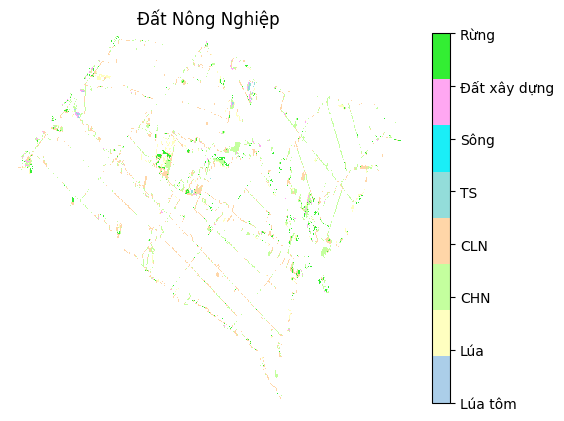

/tmp/ipykernel_2171/2515831464.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


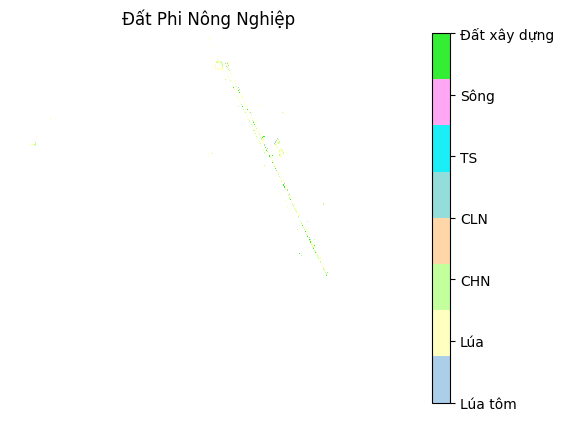

/tmp/ipykernel_2171/2515831464.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


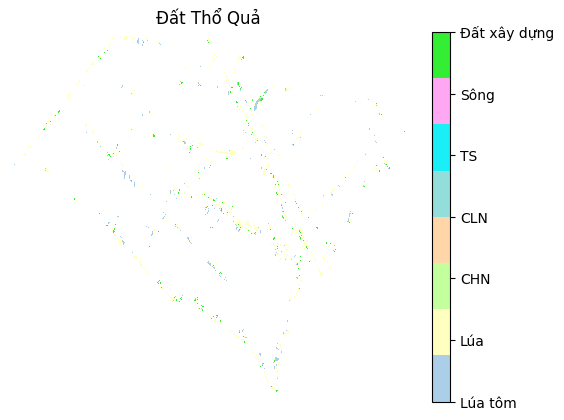

In [20]:
for k, v in sub_result.items():
    rs = merge_arrays(v, nodata = np.nan)
    rs.rio.to_raster(f"{save_path}/{k}-sub.tif")
    img = rs.plot(cmap=cmap, add_colorbar=False)
    cbar = plt.colorbar(img)
    cbar.ax.set_yticklabels(labels)
    plt.title(f'{HT_MAP[k]["name"]}')
    plt.axis('off')
    plt.show()

In [9]:
# Add the three datasets into a DataArray wth new dimension by name

import pandas as pd
xx = []

for k, v in result.items():
    rs = merge_arrays(v, nodata = np.nan)
    xx.append(rs.squeeze(drop=True))
xx = xr.concat(xx, pd.Index([HT_MAP[x]['name'] for x in HT_MAP], name='name'))

In [10]:
# Holoviews with "groupby" name dimension - adds a "name" dropdown widget to select between the three datasets

import hvplot.xarray
from holoviews import opts
from datashader import reductions
from bokeh.models.tickers import FixedTicker

colorval = list(range(len(colors)))
options = {
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'height': 400,
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
xx.hvplot(
    groupby = 'name',
    rasterize = True,                        # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   [name]
   :Image   [y,x]   (value)